## Series estacionarias
Una serie es considerada estacionaria si su distribución no cambia con el tiempo. El supuesto es que cada serie es generada por un Proceso Generador de Datos (PGD) que no cambia su distribución. Existe dos definiciones de estacionariedad:
### 1. Estacionariedad débil:
$y_t$ es debilmente estacionaria si sus dos primeros momentos individuales no dependen del tiempo. Se cumple las propiedades:
* $E(y_t)=\mu<\infty$ 
* $Var(y_t)=E[(y_t-\mu)^2]=\sigma^2<\infty$
* $Cov(y_t, y_{t-k}) = E[(y_t-\mu)(y_{t-k}-\mu)]=\gamma_k<\infty; \hspace{0.5cm} k>0$

donde $k$ es la separación entre observaciones. En ese sentido, la correlación entre dos periodos no depende del tiempo, sino de la distancia. Esta definición es la más usada, debido a que no es tan restrictiva.

### 2. Estacionariedad fuerte:
$y_t$ es estrictamente estacionaria si la distribución conjunta $F(y_1, y_2, ... yj)$ no depende del tiempo, para todo j. Es decir: $$F(y_1, y_2, ... yj)=F(y_{1+s}, y_{2+s}, ... y{j+s})$$
Esta definición requiere que todos los momentos sean independientes del tiempo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

import warnings
warnings.simplefilter("ignore")

%run "../utils.py"

### ACF y PACF
La autocovarianza de un serie $y_t$ se define por $Cov(y_t, y_{t-k}) = \gamma_k$, y mide la relación entre un periodo y $k$ periodos hacia atrás.
La autocovarianza, por su parte, es la covarianza divida por las desviaciones estándar de cada serie:

$$
\begin{align}
\dfrac{Cov(y_t, y_{t-k})}{Var(y_t)^{1/2}Var(y_{t-k})^{1/2}} = \rho_k
\end{align} \label{eq2}
$$

#### Propiedades
* $\gamma_0 = \sigma^2$
* $|\gamma_0| \leqslant \gamma_0$
* $\gamma_{-k} = \gamma_l$
* $\rho_0 = 1$
* $|\rho_0| \leqslant \rho_0$
* $\rho_{-k} = \rho_l$

#### Función de Autocorrelación (ACF)
Secuencia de autocorrelación para diferentes $k$.

Dado una serie simple definida por $y_t = \phi y_{t-1} + e_t$. La ACF sería $\rho_k = \phi^k$. De esta manera, a medida que el coeficiente $\phi$ sea mayor, el decaimiento en la ACF y la correlación con el pasado será muy lento. 

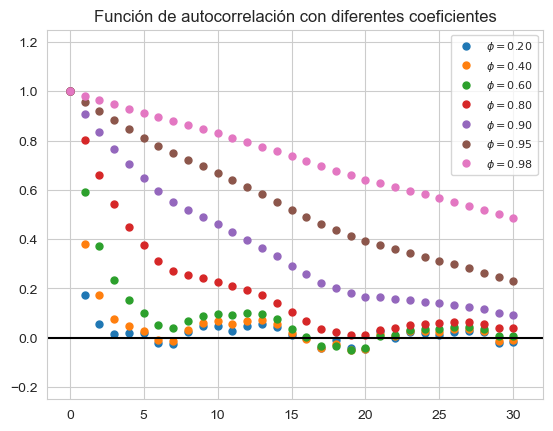

In [2]:
# define_arma_model es una función de `utils.py`
phi_02  = define_arma_model([0.20], [0], 1_000)
phi_04  = define_arma_model([0.40], [0], 1_000)
phi_06  = define_arma_model([0.60], [0], 1_000)
phi_08  = define_arma_model([0.80], [0], 1_000)
phi_09  = define_arma_model([0.90], [0], 1_000)
phi_095 = define_arma_model([0.95], [0], 1_000)
phi_098 = define_arma_model([0.98], [0], 1_000)

fig, ax = plt.subplots(1)

plot_acf(phi_02,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.20$", alpha=1)
plot_acf(phi_04,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.40$", alpha=1)
plot_acf(phi_06,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.60$", alpha=1)
plot_acf(phi_08,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.80$", alpha=1)
plot_acf(phi_09,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.90$", alpha=1)
plot_acf(phi_095, ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.95$", alpha=1)
plot_acf(phi_098, ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.98$", alpha=1)
plt.axhline(y=0, color="black", linestyle="-")

ax.set_ylim([-.25, 1.25])
plt.title("Función de autocorrelación con diferentes coeficientes")
plt.legend(fontsize=8)

plt.savefig("../figures/acfs_phi.pdf")
plt.show()

#### Función Parcial de Autocorrelación (PACF)
Halla la autocorrelación de dos periodos sin contar la influencia de los periodos que los separan.

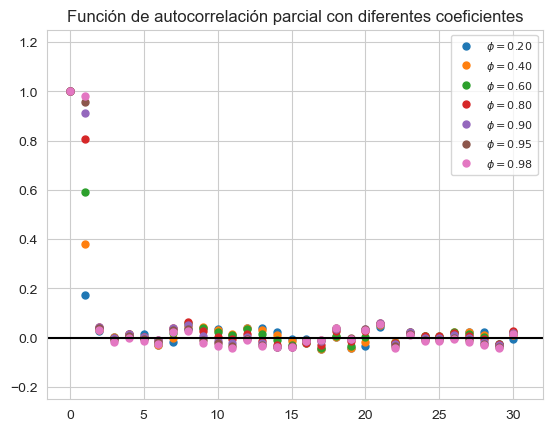

In [3]:
# define_arma_model es una función de `utils.py`
phi_02  = define_arma_model([0.20], [0], 1_000)
phi_04  = define_arma_model([0.40], [0], 1_000)
phi_06  = define_arma_model([0.60], [0], 1_000)
phi_08  = define_arma_model([0.80], [0], 1_000)
phi_09  = define_arma_model([0.90], [0], 1_000)
phi_095 = define_arma_model([0.95], [0], 1_000)
phi_098 = define_arma_model([0.98], [0], 1_000)

fig, ax = plt.subplots(1)

plot_pacf(phi_02,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.20$", alpha=1)
plot_pacf(phi_04,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.40$", alpha=1)
plot_pacf(phi_06,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.60$", alpha=1)
plot_pacf(phi_08,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.80$", alpha=1)
plot_pacf(phi_09,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.90$", alpha=1)
plot_pacf(phi_095, ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.95$", alpha=1)
plot_pacf(phi_098, ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.98$", alpha=1)
plt.axhline(y=0, color="black", linestyle="-")

ax.set_ylim([-.25, 1.25])
plt.title("Función de autocorrelación parcial con diferentes coeficientes")
plt.legend(fontsize=8)

plt.savefig("../figures/pacfs_phi.pdf")
plt.show()

### Procesos estacionarios
#### 1. Ruido blanco
El modelo más básico estacionario es llamado ruido blanco y se define por un proceso de errores {$e_t$} con media cero y varianza $\sigma^2$: $$y_t = e_t, \hspace{0.5cm} e_t \sim N(0, 1)$$
Se comprueba que la serie es estacionaria dado que:

$E(y_t)=E(e_t)=0<\infty$ 

$Var(y_t)=V(e_t)=1<\infty$

Dado que los errores no están autocorrelacionados con el tiempo: 

$E(e_t e_\tau)=0<\infty, \hspace{0.5cm} t\neq\tau,$

las ACFs y PACFs decaen inmediatamente a valores no significativos con $k>0$

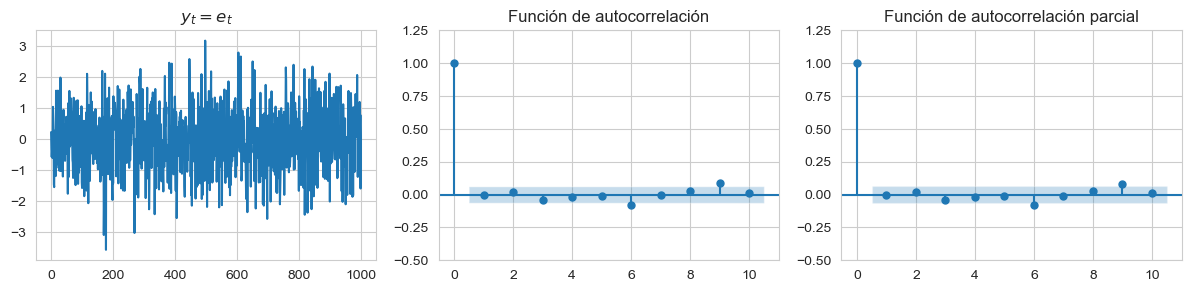

In [4]:
np.random.seed(19)

mu = 0
sd = 1
smpl = 1_000

nwn = np.random.normal(mu, sd, smpl)

# Serie
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].plot(nwn)
ax[0].set_title(r"$y_t=e_t$")

# ACF y PACF
plot_acf(nwn, ax=ax[1], lags=10, use_vlines=True, alpha=0.05)
plot_pacf(nwn, ax=ax[2], lags=10, use_vlines=True, alpha=0.05)
ax[1].set_title("Función de autocorrelación")
ax[2].set_title("Función de autocorrelación parcial")
ax[1].set_ylim([-0.5, 1.25])
ax[2].set_ylim([-0.5, 1.25])

fig.tight_layout(pad=1)
plt.show()

#### 2. MA(1)
El proceso _moving average_ de primer orden es donde el término de ruido blanco incluye un rezago: $$y_t = \mu + e_t + \theta e_{t-1}$$
Donde la media $\mu$ y el coeficiente $\theta$ son constante. Se comprueba que la serie es estacionaria dado que:

$E(y_t)=E(\mu + e_t+\theta e_{t-1})=\mu<\infty$ 

$ Var(y_t) =E(Y_t-\mu)^2 =E(e_t+\theta e_{t-1})^2 $ 

$ \hspace{1.5cm} = E(e^2_t+2 \theta e_t e_{t-1}) = \sigma^2+\theta^2 \sigma^2 $

$ \hspace{1.5cm} = (1+\theta^2)\sigma^2 <\infty $

Esta serie sí tendrá autocorrelación hasta de un rezago:

$ E(Y_t-\mu)(Y_{t-1}-\mu) = E(e_t+\theta e_{t-1})(e_{t-1}+\theta e_{t-2})$

$ \hspace{3.6cm} = E(e_t e_{t-1}+\theta e^2_{t-1} + \theta e_t e_{t-2} + \theta^2 e_{t-1} e_{t-2})$

$ \hspace{3.6cm} = \theta \sigma^2 $

No obstante, no habrá autocorrelación con más rezagos hacia adelante:

$\begin{align}
E(Y_t-\mu)(Y_{t-k}-\mu) &= E(e_t+\theta e_{t-1})(e_{t-k}+\theta e_{t-k-1}) = 0; \hspace{0.5cm} k>0
\end{align}$

Por ende, la función de autocorrelación es la siguiente:

$\rho_1 = \dfrac{\gamma_1}{\gamma_0} = \dfrac{\theta \sigma^2}{(1+\theta^2)\sigma^2} = \dfrac{\theta}{(1+\theta^2)}$

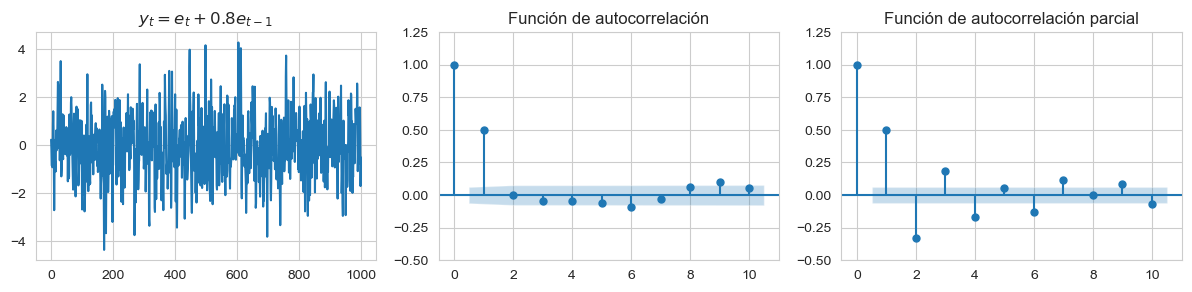

In [5]:
np.random.seed(19)

# Definiendo los parámetros de los componentes AR y MA
ar_p = np.array([0])
ma_p = np.array([0.8])

# Incluyo una constante. Para el caso del AR debo colocarlo en negativo
ar = np.r_[1, -ar_p]
ma = np.r_[1, ma_p]

ma1 = arma_generate_sample(ar, ma, nsample=1_000)
ma1 = pd.Series(ma1)

# Serie
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].plot(ma1)
ax[0].set_title(r"$y_t=e_t+0.8e_{t-1}$")

# ACF y PACF
plot_acf(ma1, ax=ax[1], lags=10, use_vlines=True, alpha=0.05)
plot_pacf(ma1, ax=ax[2], lags=10, use_vlines=True, alpha=0.05)
ax[1].set_title("Función de autocorrelación")
ax[2].set_title("Función de autocorrelación parcial")
ax[1].set_ylim([-0.5, 1.25])
ax[2].set_ylim([-0.5, 1.25])

fig.tight_layout(pad=1)
plt.show()

#### 3. MA(q)
El proceso _moving average_ de orden _q_ se caracteriza por lo siguiente: $$y_t = \mu + e_t + \theta e_{t-1} + \theta^2 e_{t-2}+ ... \theta^q e_{t-q}$$
donde el modelo proceso se puede resumir en:

$
y_t = \mu + \sum_{k=0}^{q} \theta^k e_{t-k}
$
 
La esperanza y varianza están definidos por:

$
E(y_t)= \mu + E(e_t)+\theta E(e_{t-1}) + \theta^2 E(e_{t-2}) + ... + \theta^q E(e_{t-q}) = \mu
$

$
V(y_t) = E(e_t+ \theta e_{t-1}+ \theta^2 E(e_{t-2}) + ... + \theta^q E(e_{t-q})^2
$



#### 4. AR(1)
Un modelo autorregreseivo de primer orden, satisface la siguiente ecuación: $$y_t = c + \phi y_{t-1} + e_t$$

Los errores son ruido blanco y satisfacen las condiciones previamente explicadas. Si se satisface que $|\phi|<0$, entonces el proceso es covarianza estacionario y tienen una solución estable caracterizada por una secuencia de choques:

$ y_t  = (c+e_t) + \phi (c+e_{t-1}) + \phi^2 (c+e_{t-2}) + \phi^3 (c+e_{t-3}) + + ... $

$ \hspace{0.5cm} = \dfrac{c}{1-\phi} + \phi e_{t-1} + \phi^2 e_{t-2} + \phi^3 e_{t-3} + ... $

De esta manera, se encuentra que los resultados de un AR(1) son los mismos que de un MA($\infty$). Por ende, el modelo es estacionario ya que cumple con lo siguiente:

$ E(y_t) = \dfrac{c}{1-\phi} = \mu < \infty$

$ V(y_t) = E(y_t - \mu)^2$

$ \hspace{1.1cm} = E(e_t + \phi e_{t-1} + \phi^2 e_{t-2} + \phi^3 e_{t-3} +...)^2 $

$ \hspace{1.1cm} = (1 + \phi^2 + \phi^4 + \phi^6 + ... ) \sigma^2  = \frac{\sigma^2}{1-\phi^2} < \infty$

La autocovarianza se define por:

$
\gamma_k = E(y_t - \mu)(y_{t-k} - \mu) = (\frac{\sigma^2}{1-\phi^2}) \phi^k
$

De tal manera que la autocorrelación se define por:

$
\rho_k = \dfrac{\gamma_k}{\gamma_0} = \phi^k
$

No obstante, los resultados de estos estadísticos se pueden trabajar directamente la forma AR(1), sin necesidad de recurrir a estimarlos en su forma MA($\infty$):

$ E(y_t) = c + \phi E(y_{t-1}) + E(e_t) $

$ \mu = c + \phi \mu $

$ \mu = \dfrac{c}{1-\phi} $

La varianza: 

$ y_t = \mu (1-\phi) + \phi y_{t-1} + e_t $

$ y_t - \mu = \phi (y_{t-1} - \mu) + e_t $

$ E(y_t - \mu)^2 = \phi^2 E(y_{t-1} - \mu)^2 + 2\phi E[(y_{t-1} - \mu) e_t] + E(e^2_t) $

$ \gamma_0 = \phi^2 \gamma_0 + \sigma^2 $

$
\gamma_0 = \frac{\sigma^2}{1-\phi^2} < \infty
$

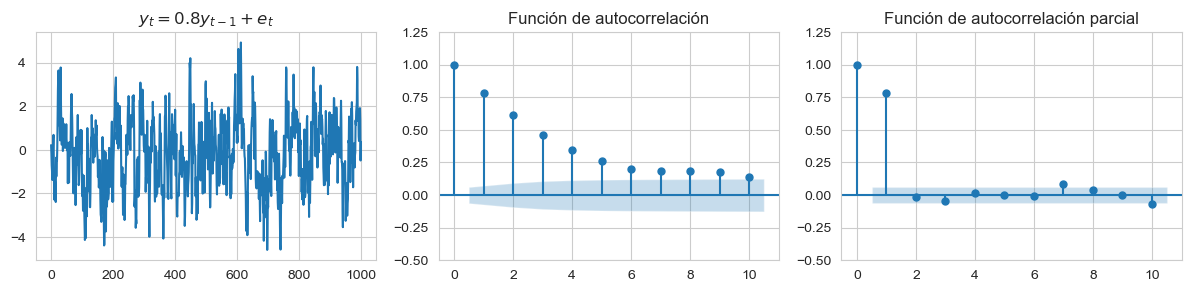

In [6]:
np.random.seed(19)

# Definiendo los parámetros de los componentes AR y MA
ar_p = np.array([0.8])
ma_p = np.array([0])

# Incluyo una constante. Para el caso del AR debo colocarlo en negativo
ar = np.r_[1, -ar_p]
ma = np.r_[1, ma_p]

ar1 = arma_generate_sample(ar, ma, nsample=1_000)
ar1 = pd.Series(ar1)

# Serie
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].plot(ar1)
ax[0].set_title(r"$y_t=0.8 y_{t-1}+e_t$")

# ACF y PACF
plot_acf(ar1, ax=ax[1], lags=10, use_vlines=True, alpha=0.05)
plot_pacf(ar1, ax=ax[2], lags=10, use_vlines=True, alpha=0.05)
ax[1].set_title("Función de autocorrelación")
ax[2].set_title("Función de autocorrelación parcial")
ax[1].set_ylim([-0.5, 1.25])
ax[2].set_ylim([-0.5, 1.25])

fig.tight_layout(pad=1)
plt.show()

#### 5. AR(p)
.
.
.


#### 6. ARMA(1, 1)

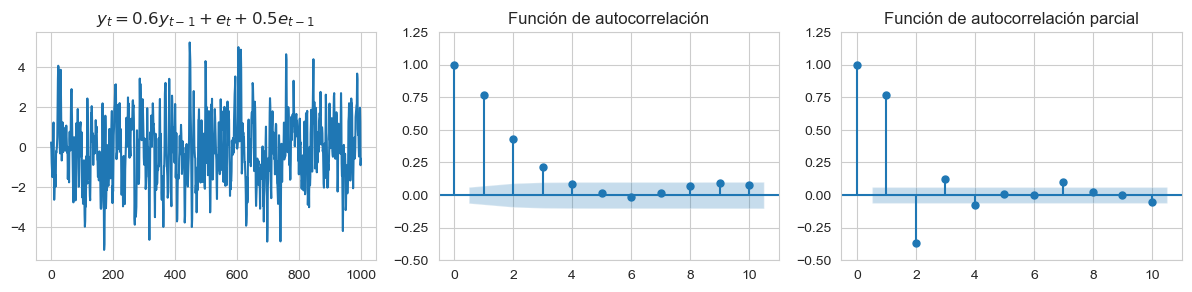

In [7]:
np.random.seed(19)

# Definiendo los parámetros de los componentes AR y MA
ar_p = np.array([0.6])
ma_p = np.array([0.5])

# Incluyo una constante. Para el caso del AR debo colocarlo en negativo
ar = np.r_[1, -ar_p]
ma = np.r_[1, ma_p]

arma11 = arma_generate_sample(ar, ma, nsample=1_000)
arma11 = pd.Series(arma11)

# Serie
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].plot(arma11)
ax[0].set_title(r"$y_t=0.6 y_{t-1}+e_t+0.5 e_{t-1}$")

# ACF y PACF
plot_acf(arma11, ax=ax[1], lags=10, use_vlines=True, alpha=0.05)
plot_pacf(arma11, ax=ax[2], lags=10, use_vlines=True, alpha=0.05)
ax[1].set_title("Función de autocorrelación")
ax[2].set_title("Función de autocorrelación parcial")
ax[1].set_ylim([-0.5, 1.25])
ax[2].set_ylim([-0.5, 1.25])

fig.tight_layout(pad=1)
plt.show()

#### 7. ARMA(p, q)

### Estimación de modelo

In [8]:
model = tsa.arima.ARIMA(arma11, order=(1,0,1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1409.611
Date:                Fri, 10 Feb 2023   AIC                           2827.222
Time:                        18:33:34   BIC                           2846.853
Sample:                             0   HQIC                          2834.683
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1377      0.115     -1.200      0.230      -0.363       0.087
ar.L1          0.5931      0.032     18.659      0.000       0.531       0.655
ma.L1          0.4902      0.034     14.462      0.0

### Selección de modelo

* Akaike

* BIC

* HQIC

In [9]:
infcrit = arma_order_select_ic(
    arma11, max_ar=4, max_ma=4, ic=["aic", "bic", "hqic"]
)

print(f"AIC: {infcrit.aic_min_order}\nBIC: {infcrit.bic_min_order}\nHQIC:{infcrit.hqic_min_order}")

AIC: (4, 4)
BIC: (1, 1)
HQIC:(1, 1)


### Análisis de residuos
Tras la estimacion de un modelo, los residuos deberian comportarse como un ruido blanco. Es decir, no deberia tener autorrelación serial

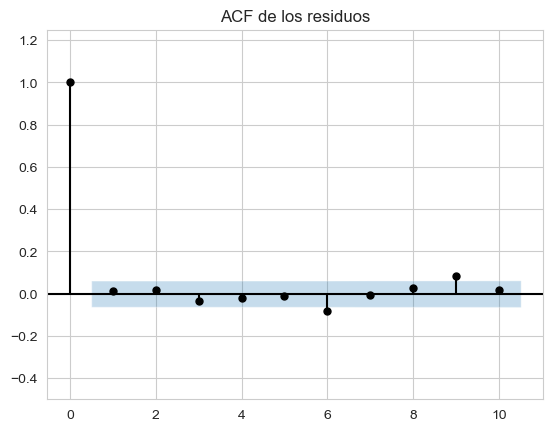

In [10]:
resids = model.resid

#### Gráfico al lado de las proyecciones in-sample
fig, ax = plt.subplots(1)
plot_acf(
    resids, ax=ax, lags=10,
    title="ACF de los residuos", color="black",
    vlines_kwargs={"colors": "black"})

plt.ylim([-.5, 1.25])

plt.show()

Aunque, igual se podría graficar todos los resultados en uno

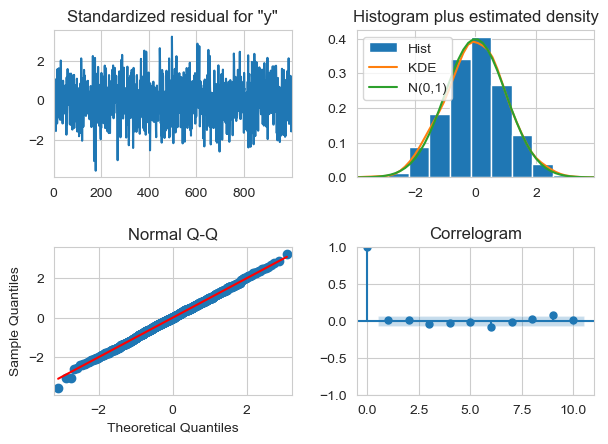

In [11]:
fig = model.plot_diagnostics()

fig.tight_layout(pad=2)
plt.show()

Tambien se podria realizar el test de Durbin-Watson y el de Breush-Pagan

In [12]:
print(
f"El test de Durbin-Watson da como resultado {np.round(durbin_watson(resids), 2)}, por lo que no habria autocorrelacion serial. \
El test de Breusch-Pagan da como p-value a {np.round(acorr_breusch_godfrey(model), 3)[1]}, por lo que no se puede rechazar la hipotesis\
nula de autocorrelacion serial."
) 

El test de Durbin-Watson da como resultado 1.97, por lo que no habria autocorrelacion serial. El test de Breusch-Pagan da como p-value a 0.1, por lo que no se puede rechazar la hipotesisnula de autocorrelacion serial.


### Proyecciones in-sample

Una vez estimado el modelo, se puede graficar ambos juntos

In [13]:
model_est = model.predict()


fig = plt.figure()
fig = plt.plot(serie, label="Serie")
fig = plt.plot(model_est, label="Estimado")

plt.legend()
plt.title("Gráfico de la serie original con el estimado por el modelo")

plt.show()

NameError: name 'serie' is not defined

<Figure size 640x480 with 0 Axes>

### Proyecciones out-sample

In [ ]:
# Estimacion
model_f = model.get_forecast(steps=200)

# Proyeciones
model_mean = model_f.predicted_mean
model_ci = model_f.conf_int()

# Generando los DataFrames
fc_series = pd.Series(model_mean)
lower_series = pd.Series(model_ci["lower y"])
upper_series = pd.Series(model_ci["upper y"])

In [ ]:
# Plot
plt.figure()

plt.plot(serie, label="Original")
plt.plot(fc_series, label="Forecast")

# Fill
plt.fill_between(lower_series.index, lower_series, upper_series, color="grey", alpha=0.2)

plt.title("Original vs Forecast")
plt.legend(loc="upper left", fontsize=8)

plt.show()

#### Referencias:
* https://www.statsmodels.org/stable/tsa.html
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/